# iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv feature 사용 
    - in_features : petal.length 등  
    - out_feature : petal.width 1개
- 구현 프레임 워크 : pytorch

## [1] 모듈 로딩 및 데이터 준비

In [305]:
# 모듈 로딩 

import torch                                # 텐서 및 수치 계산 함수 관련 모듈 
import torch.nn as nn                       # 인공신경망 관련 모듈 
import torch.nn.functional as F             # 손실, 거래 등 함수 관련 모듈 
import torch.optim as optimizer             # 최적화 기법 관련 모듈 

import pandas as pd                         # 데이터 파일 분석 과련 모듈 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from torchmetrics.regression import R2Score  # 성능지표 관련 모듈 - 추가 설치 
from torchinfo import summary                # 모델 정보 관련 모듈 - 추가 설치 

In [306]:
torch.manual_seed(1)

# 저장 및 실행 위치 설정 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE => {DEVICE}')

DEVICE => cpu


In [307]:
# 데이터 로딩 : csv -> DF 

DATA_FILE = '../DATA/iris.csv'

iris_df = pd.read_csv(DATA_FILE, usecols=[0,1,2,3])
iris_df.head(2)


,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


# [2] 모델 준비 
- 학습 방법 : 지도학습 - 회귀 
- 알고리즘 : 선형관계 -> 선형모델 -> nn.Linear

In [308]:
# 모델 설계 
# 입력층에 입력값 => sepal.length, sepal.width, petal.length
# 출력층의 출력값/타겟 => petal.width 1개 

# 입력층 : 입력 피쳐 3,                     출력 입력층에 존재하는 퍼셉트론 개수 10,     AF ReLU
#                                                    |
#                                                    | ReLU
#                                 ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ 
#                                 ↓
# 은닉층 : (입력층의 출력 받음) 입력 10,     출력 입력층에 존재하는 퍼셉트론 개수 5,      AF ReLU
#                                                    |
#                                                    | ReLU
#                                ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ 
#                               ↓
# 출력층 : (은닉층의 출력 받음) 입력 5,      출력 타겟/라벨 개수 1,                     AF None

model = nn.Sequential( nn.Linear(3,10), 
                      nn.ReLU(), 
                      nn.Linear(10,5),
                      nn.ReLU(), 
                      nn.Linear(5,1)
                      )

In [309]:
# 가중치와 절편 확인 
for name, param in model.named_parameters():

    print(f'[{name}] {param}\n')

[0.weight] Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119],
        [ 0.2710, -0.5435,  0.3462],
        [-0.1188,  0.2937,  0.0803],
        [-0.0707,  0.1601,  0.0285],
        [ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023],
        [ 0.5047,  0.1797, -0.2150],
        [-0.3487, -0.0968, -0.2490],
        [-0.1850,  0.0276,  0.3442],
        [ 0.3138, -0.5644,  0.3579]], requires_grad=True)

[0.bias] Parameter containing:
tensor([ 0.1613,  0.5476,  0.3811, -0.5260, -0.5489, -0.2785,  0.5070, -0.0962,
         0.2471, -0.2683], requires_grad=True)

[2.weight] Parameter containing:
tensor([[ 0.3103, -0.1338,  0.2371,  0.0037, -0.1666,  0.1625, -0.1679,  0.0930,
         -0.0913, -0.0347],
        [-0.3040, -0.1508,  0.1716, -0.0769,  0.3150,  0.2535, -0.0148, -0.2111,
          0.1926,  0.0981],
        [-0.2044,  0.2054,  0.1920,  0.2805, -0.1773, -0.0521, -0.0061,  0.0462,
         -0.2400, -0.2244],
        [ 0.1720, -0.0742,  0.1545,  0.0180,  0.1038,  0

In [310]:
# 모델 구조 확인

print(model)
summary(model,input_size=(3,)) 
# 3개 넣었을 때 모델이 차지하는 용량 등 파악 - 실질적으로 안에 숫자는 의미 x 

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1]                       --
├─Linear: 1-1                            [10]                      40
├─ReLU: 1-2                              [10]                      --
├─Linear: 1-3                            [5]                       55
├─ReLU: 1-4                              [5]                       --
├─Linear: 1-5                            [1]                       6
Total params: 101
Trainable params: 101
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

w1, w2, w3, b 총 4개에 퍼셉트론이 10개라서 총 40개의 변수 필요 

## [3] 최적화 인스턴스 준비 

In [311]:
# 모델의 가중치와 절편 최적화 ==> 인스턴스에 전달 
adam_optim = optimizer.Adam(model.parameters(), lr = 0.1)

# [4] 학습 ==> 개발자가 구현 

### [4-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행하거나 또는 학습 전 진행 

In [312]:
# 피쳐와 타겟 분리

feature_df = iris_df[iris_df.columns[:-1]]
target_df = iris_df[['petal.width']]

print(feature_df.shape, target_df.shape)

(150, 3) (150, 1)


In [313]:
from sklearn.model_selection import train_test_split

# train, test 쪼개기 
x_train, x_test, y_train, y_test = train_test_split(feature_df, target_df, test_size=0.2)

# train, valid 쪼개기 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

print(f'[Feature] Train {x_train.shape}, Test {x_test.shape}, Val {x_val.shape}')
print(f'[Target] Train {y_train.shape}, Test {y_test.shape}, Val {y_val.shape}')

[Feature] Train (96, 3), Test (30, 3), Val (24, 3)
[Target] Train (96, 1), Test (30, 1), Val (24, 1)


### [4-2] 학습 진행 
- 학습 횟수 결정 ==> 에포크 설정 
- 배치 크기 결정 
- 배치 개수 계산 

In [314]:
EPOCH = 100                                 # 처음 ~ 끝까지 공부하는 횟수 
BATCH_SIZE = 15                             # 1에포크에서 한 번 학습할 분량 크기 
BATCH_CNT = x_train.shape[0] // BATCH_SIZE  # 1에포크에서 총 학습 횟수이면서 업데이트 횟수 
# 몫 연산자로 등분  -> 총 9등분 

print(f'EPOCH : {EPOCH}, BATCH_SIZE : {BATCH_SIZE}, BATCH_CNT : {BATCH_CNT}')


EPOCH : 100, BATCH_SIZE : 15, BATCH_CNT : 6


-> 총 9000번 (EPOCH * BATCH_SIZE * BATCH_CNT) 번 업데이트 

In [315]:
# 테스트/검증 함수 
# => 가중치, 절편 업데이트 x, 최적화 미진행 
# => 현재 가중치와 절편값으로 테스트 진행 

# 모델 학습 함수 
def testing(test_df, target_df, kind='Val'):

    # tensor 화 
    test_ts = torch.FloatTensor(test_df.values).to(DEVICE) # GPU 있으면 GPU에 넣음 
    target_ts = torch.FloatTensor(target_df.values).to(DEVICE) # GPU 있으면 GPU에 넣음 

    with torch.no_grad():
        # -(1) 학습 진행 - forward 
        pre_y = model(test_ts)
        print(f'{pre_y.shape}')

        # -(2) 오차계산 - 손실함수 
        loss = F.mse_loss(pre_y, target_ts)
        # loss_history.append(loss.item()) # tensor로 들어가서 item으로 뺌 

        # -(3) 성능 평가 - R2
        r2 = R2Score()(pre_y, target_ts)
      

        # -(4) 학습 결과 출력 및 저장 
        print(f'[{kind}] LOSS : {loss}, R2 : {R2Score()(pre_y, target_ts)}')

    return loss, r2 # R2Score()(pre_y, target_ts) # R2Score()(pre_y, target_ts) -> r2

In [316]:
# 모델 학습 함수 
def training2(feature_ts, target_ts, val_ts, val_target_ts):

    loss_history = [[],[]] # [train, val]
    r2_history = [[],[]] 

    for epoch in range(EPOCH):
        # 배치 크기 만큼 학습 진행 

        # 배치 손실 저장 변수 
        bs_loss = 0
        bs_r2 = 0

        for i in range(BATCH_CNT):
            start = i * BATCH_SIZE
            end = start + BATCH_SIZE
            # print(start, end)

            # BS 크기 만큼만 데이터 추출해서 Tensor화 진행 
            BSX_train = torch.FloatTensor(x_train[start:end].values).to(DEVICE) # GPU 있으면 GPU에 넣음 
            BSY_train = torch.FloatTensor(y_train[start:end].values).to(DEVICE) # GPU 있으면 GPU에 넣음 

            # print(BSX_train.shape, BSX_train.device, BSX_train.dtype) # 배치크기만큼만 가져옴 
            # print(BSY_train.shape, BSY_train.device, BSY_train.dtype) 


            # -(1) 학습 진행 - forward 
            pre_y = model(BSX_train)
            # print(f'pre_y.shape : {pre_y.shape}')

            # -(2) 오차계산 - 손실함수 
            loss = F.mse_loss(pre_y, BSY_train)
            bs_loss += loss.item()
            bs_r2 += (R2Score()(pre_y, BSY_train)).item()
            # loss_history[0].append(loss.item()) # tensor로 들어가서 item으로 뺌 

            # -(3) 최적화 - 가중치, 절편 업데이트 backward 
            adam_optim.zero_grad()
            loss.backward()
            adam_optim.step()

        # -(4) 검증 - 모델이 제대로 만들어지는 검사용 
        val_loss, val_r2 = testing(val_ts, val_target_ts)
        loss_history[1].append(val_loss)
        r2_history[1].append(val_r2)

        # 에포크 단위 손실과 성능지표 
        loss_history[0].append(bs_loss/BATCH_CNT)

        r2_history[0].append(bs_r2/BATCH_CNT)

        # -(4) 학습 결과 출력 및 저장 
        print(f'[{epoch}/{EPOCH}]\n Train_LOSS : {loss_history[0][-1]}, R2 : {r2_history[0][-1]}') # 0번 : train 
        print(f'Val_LOSS : {loss_history[1][-1]}, R2 : {r2_history[1][-1]}') # 1번 : val

    return loss_history,r2_history

    배치사이즈마다 손실과 성능지표가 나오므로 다 구해서 평균

In [317]:
loss, r2 = training2(x_train, y_train, x_val, y_val)

torch.Size([24, 1])
[Val] LOSS : 0.5500092506408691, R2 : -0.1796884536743164
[0/100]
 Train_LOSS : 0.6534397651751837, R2 : -0.20997206370035806
Val_LOSS : 0.5500092506408691, R2 : -0.1796884536743164
torch.Size([24, 1])
[Val] LOSS : 0.6144837737083435, R2 : -0.317976713180542
[1/100]
 Train_LOSS : 0.34348055720329285, R2 : 0.3747036854426066
Val_LOSS : 0.6144837737083435, R2 : -0.317976713180542
torch.Size([24, 1])
[Val] LOSS : 0.13566052913665771, R2 : 0.7090282440185547
[2/100]
 Train_LOSS : 0.3064757486184438, R2 : 0.45318735639254254
Val_LOSS : 0.13566052913665771, R2 : 0.7090282440185547
torch.Size([24, 1])
[Val] LOSS : 0.040808070451021194, R2 : 0.9124727249145508
[3/100]
 Train_LOSS : 0.1440747765203317, R2 : 0.7264139354228973
Val_LOSS : 0.040808070451021194, R2 : 0.9124727249145508
torch.Size([24, 1])
[Val] LOSS : 0.07616158574819565, R2 : 0.8366446495056152
[4/100]
 Train_LOSS : 0.07576246000826359, R2 : 0.8647110760211945
Val_LOSS : 0.07616158574819565, R2 : 0.836644649505

In [318]:
loss

[[0.6534397651751837,
  0.34348055720329285,
  0.3064757486184438,
  0.1440747765203317,
  0.07576246000826359,
  0.13372121875484785,
  0.1341555298616489,
  0.08246484709282716,
  0.07753309359153111,
  0.09895618011554082,
  0.08302277699112892,
  0.07318205758929253,
  0.0857578410456578,
  0.08680697903037071,
  0.07701327838003635,
  0.07630162624021371,
  0.08227720918754737,
  0.08083096581200759,
  0.07494637121756871,
  0.07360147250195344,
  0.07702771946787834,
  0.07662578051288922,
  0.07218089575568835,
  0.07089226134121418,
  0.07202117703855038,
  0.0719506765405337,
  0.07139914731184642,
  0.06961565464735031,
  0.06785097345709801,
  0.0681246208647887,
  0.06862066065271695,
  0.06831405435999234,
  0.06611586486299832,
  0.0639453437179327,
  0.0646626294280092,
  0.06569063911835353,
  0.06523642378548782,
  0.06359246963014205,
  0.06219937403996786,
  0.06130014390995105,
  0.0608774246647954,
  0.06154534065475067,
  0.06182214772949616,
  0.06112560878197352

Text(0.5, 1.0, 'R2')

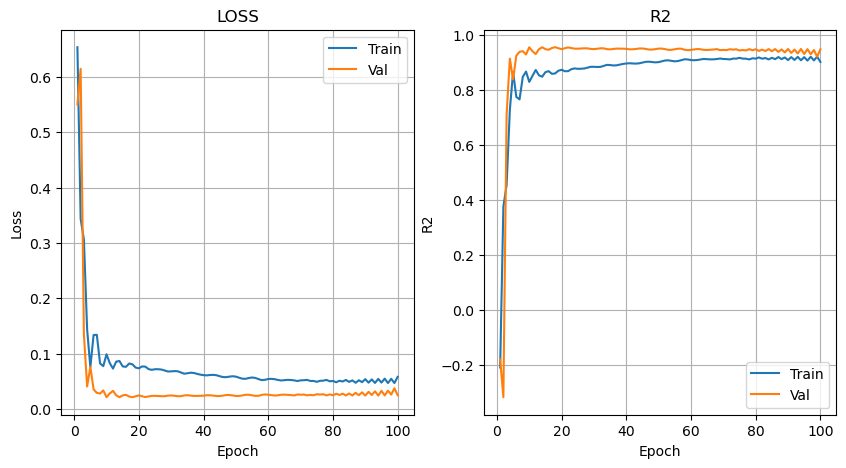

In [319]:
# 학습 후 loss 시각화 

THRESHOLD = 100 # 안 주면 전체가 나옴 => 값을 보기 어려움 => 자세히 보기 위함 => 끊기 위함 
fg, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].plot(range(1,THRESHOLD+1), loss[0][:THRESHOLD], label = 'Train')
axes[0].plot(range(1,THRESHOLD+1), loss[1][:THRESHOLD], label = 'Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('LOSS')


axes[1].plot(range(1,THRESHOLD+1), r2[0][:THRESHOLD], label = 'Train')
axes[1].plot(range(1,THRESHOLD+1), r2[1][:THRESHOLD], label = 'Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R2')
axes[1].set_title('R2')